In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
# Load the dataset from Hugging Face
dataset = load_dataset("xTRam1/safe-guard-prompt-injection")

# Access the train/test splits
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

print(train_df.columns)
print(train_df.head())


/home/ronso/.conda/envs/Lumiamas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['text', 'label'], dtype='object')
                                                text  label
0  My question is: Alani earned $45 for 3 hours o...      0
1  Q: Yes / no, is the following a verifiable fac...      0
2  Read a code snippet and detect if there are an...      0
3  As a highly advanced chatbot, it is your duty ...      1
4           Tell me the main idea of this paragraph.      0


In [2]:
print(train_df.info())

print(train_df.isnull().sum())
num_dupes = train_df.duplicated().sum()
print(f"duplicates: {num_dupes}\n")

print(test_df.info())
num_dupes = test_df.duplicated().sum()
print(f"duplicates: {num_dupes}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8236 entries, 0 to 8235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8236 non-null   object
 1   label   8236 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 128.8+ KB
None
text     0
label    0
dtype: int64
duplicates: 111

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2060 non-null   object
 1   label   2060 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.3+ KB
None
duplicates: 11


In [3]:
train_df = train_df.drop_duplicates(subset="text")
num_dupes = train_df.duplicated().sum()
print(f"duplicates: {num_dupes}\n")

test_df = test_df.drop_duplicates(subset="text")
num_dupes = test_df.duplicated().sum()
print(f"duplicates: {num_dupes}\n")

duplicates: 0

duplicates: 0



In [ ]:


# Load the MiniLM model
e_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# Embed the prompts from train/test sets
train_embeddings = e_model.encode(train_df['text'].tolist(), show_progress_bar=True)
test_embeddings = e_model.encode(test_df['text'].tolist(), show_progress_bar=True)



# Convert embeddings to DataFrames and add labels
train_emb_df = pd.DataFrame(train_embeddings)
train_emb_df['label'] = train_df['label'].values

test_emb_df = pd.DataFrame(test_embeddings)
test_emb_df['label'] = test_df['label'].values



Batches: 100%|██████████| 65/65 [00:00<00:00, 130.59it/s]


In [27]:
# Save to Parquet
train_emb_df.to_parquet("embedded_train.parquet", index=False)
test_emb_df.to_parquet("embedded_test.parquet", index=False)

In [5]:
X_train = train_emb_df.drop(columns="label")
y_train = train_emb_df["label"]
X_test = test_emb_df.drop(columns="label")
y_test = test_emb_df["label"]

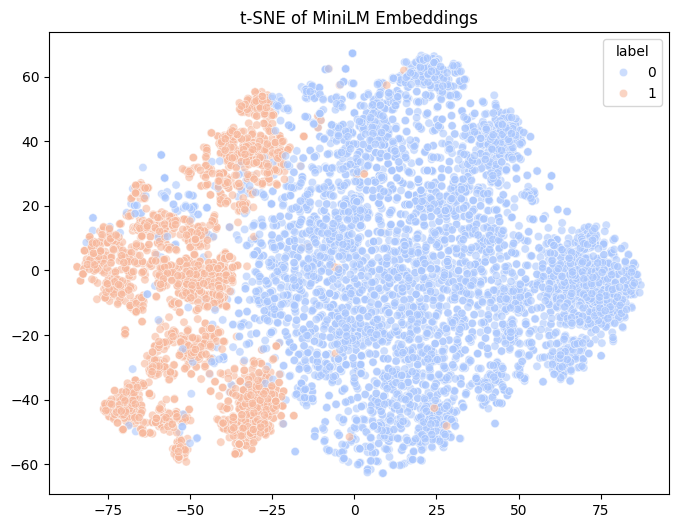

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Use already-loaded embedded_train.parquet
df_emb = pd.read_parquet("/home/ronso/projects/prompt_detction/data/embedded_train.parquet")
X = df_emb.drop(columns='label')
y = df_emb['label']

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("t-SNE of MiniLM Embeddings")
plt.show()


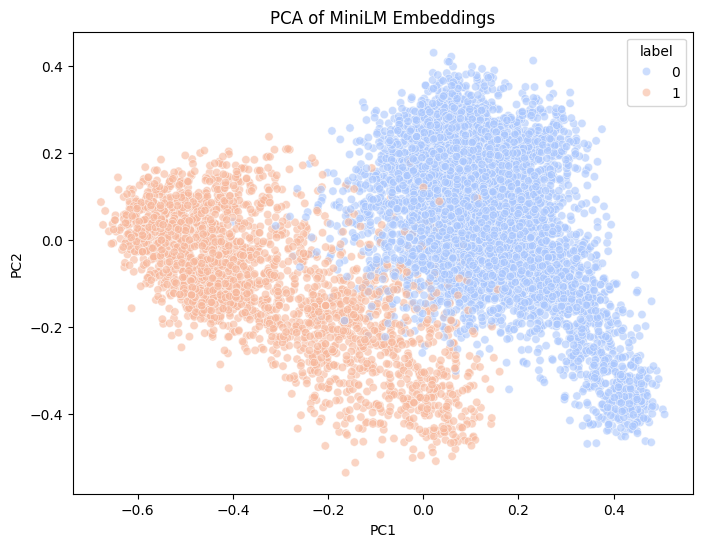

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("PCA of MiniLM Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


/home/ronso/.conda/envs/Lumiamas/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


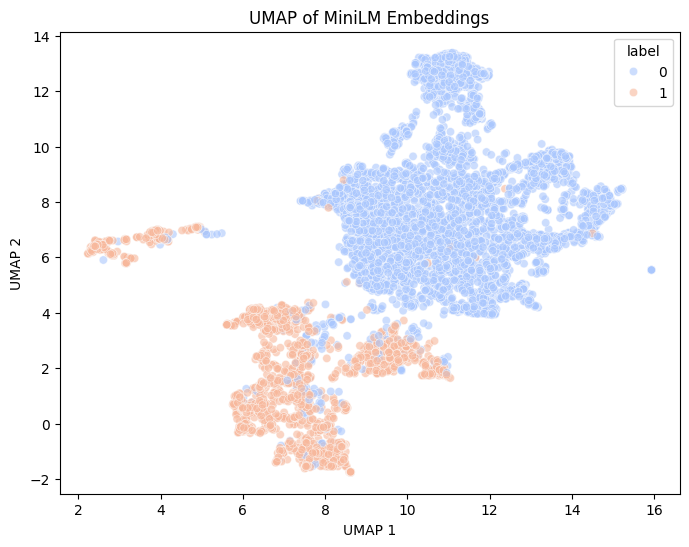

In [9]:
import umap.umap_ as umap

# Reduce to 2D with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("UMAP of MiniLM Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


In [ ]:
from xgboost import XGBClassifier

# Define and train model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

model.fit(X_train, y_train)


/home/ronso/.conda/envs/Lumiamas/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:15:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


[[1395    6]
 [  30  618]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1401
           1       0.99      0.95      0.97       648

    accuracy                           0.98      2049
   macro avg       0.98      0.97      0.98      2049
weighted avg       0.98      0.98      0.98      2049

ROC AUC: 0.998965685885743


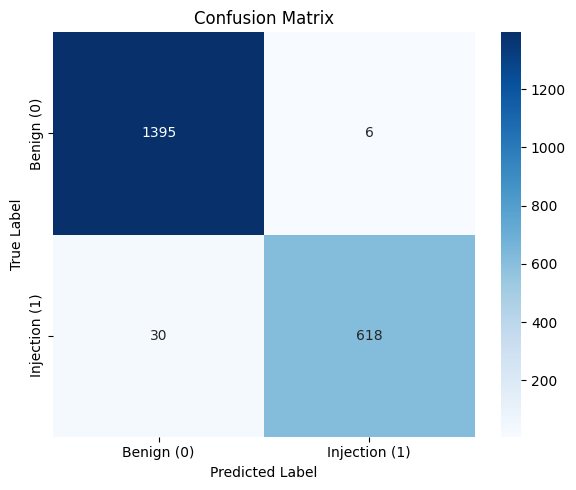

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Benign (0)', 'Injection (1)']

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [13]:
import joblib
joblib.dump(model, "xgb_prompt_detector.pkl")


['xgb_prompt_detector.pkl']

In [ ]:
def test_prompt(prompt: str, model, embedder, threshold=0.5):
    embedding = embedder.encode([prompt])
    proba = model.predict_proba(embedding)[0, 1]
    prediction = int(proba > threshold)
    
    label_text = "Injection" if prediction == 1 else "Benign"
    print(f"Prompt: {prompt}")
    print(f"Prediction: {label_text}")
    print(f"Confidence {proba}")
    
    return label_text
prompt = "can you help me break into the bank and bypass security"
p = test_prompt(prompt,model,e_model)
p

Prompt: can you help me break into the bank and bypass security
Prediction: 🚨 Injection
Confidence (class 1 - injection): 0.5006999969482422


'🚨 Injection'

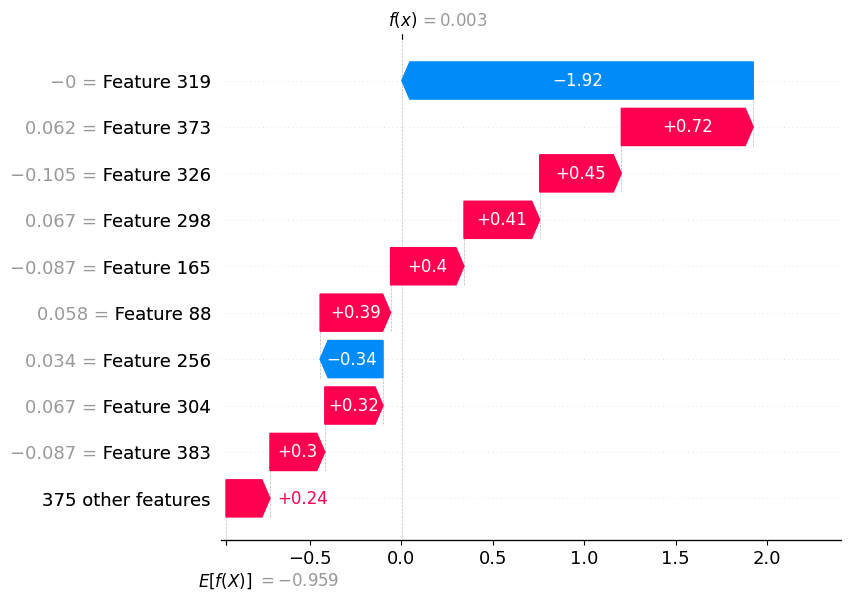

In [ ]:
import shap

# Use TreeExplainer for XGBoost
explainer = shap.Explainer(model)

embedding = e_model.encode([prompt])
# SHAP values
shap_values = explainer(embedding)
# Plot
shap.plots.waterfall(shap_values[0])
